In [1]:
import cv2

import numpy as np
from matplotlib.colors import LogNorm
from scipy import signal

# modify to where you store your project data including utils.py
datadir = "" 

utilfn = datadir + "utils.py"
# windows uses copy instead of cp
!copy "$utilfn" .
import utils

from matplotlib import pyplot as plt

/bin/bash: /home/jack/anaconda3/envs/cs445/lib/python3.10/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: copy: command not found


In [2]:
capture = cv2.imread('./capture.png')
overlay_raw = cv2.imread('./rain_overlay.png', cv2.IMREAD_UNCHANGED)

capture = cv2.cvtColor(capture, cv2.COLOR_BGR2RGB) / 255
overlay = overlay_raw.copy()

# temp follows rgb channel, overlay follows bgr channel
overlay[:, :, 0] = overlay_raw[:, :, 2] / 255.0
overlay[:, :, 1] = overlay_raw[:, :, 1] / 255.0
overlay[:, :, 2] = overlay_raw[:, :, 0] / 255.0

(Text(0.5, 1.0, 'overlay'), [], [])

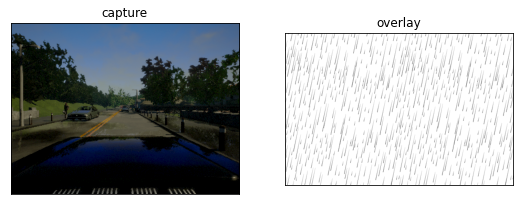

In [3]:
#Images sanity check
fig, axes = plt.subplots(1, 2, figsize=(9,5))
axes[0].imshow(capture, cmap = 'gray')
axes[0].set_title('capture'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(overlay, cmap = 'gray')
axes[1].set_title('overlay'), axes[1].set_xticks([]), axes[1].set_yticks([])

(Text(0.5, 1.0, 'overlay'), [], [])

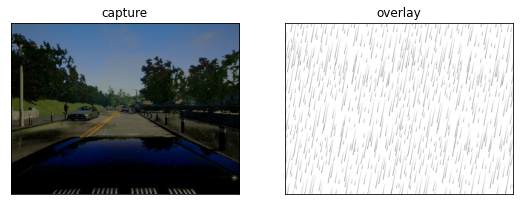

In [4]:
# Resize overlay to match the size of capture
dim = (int(capture.shape[1]), int(capture.shape[0]))
overlay_resized = cv2.resize(overlay, dim, interpolation = cv2.INTER_AREA)

fig, axes = plt.subplots(1, 2, figsize=(9,5))
axes[0].imshow(capture, cmap = 'gray')
axes[0].set_title('capture'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(overlay_resized, cmap = 'gray')
axes[1].set_title('overlay'), axes[1].set_xticks([]), axes[1].set_yticks([])

In [5]:
capture_new = capture.copy()

h = overlay_resized.shape[0]
w = overlay_resized.shape[1]
    
# loop over the image, pixel by pixel
for y in range(0, h):
    for x in range(0, w):
        for c in range(0, 3):
            a = overlay_resized[y, x, 3]/255.0
            capture_new[y, x, c] = (1-a)*capture[y, x, c] + a * overlay_resized[y, x, c]  

(Text(0.5, 1.0, 'capture_new'), [], [])

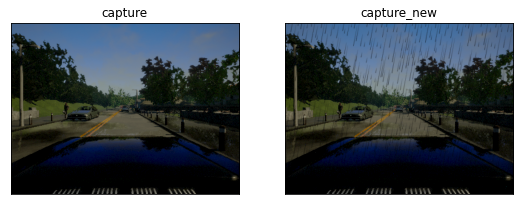

In [6]:
# Remove the opacity channel from overlay
overlay_rgb = overlay_resized[:,:,:3]

fig, axes = plt.subplots(1, 2, figsize=(9,5))
axes[0].imshow(capture, cmap = 'gray')
axes[0].set_title('capture'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(capture_new)
axes[1].set_title('capture_new'), axes[1].set_xticks([]), axes[1].set_yticks([])

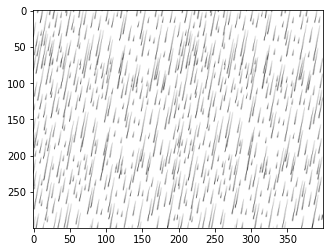

In [7]:
h = overlay_resized.shape[0]
w = overlay_resized.shape[1]

overlay_gray = np.zeros((h, w))

# loop over the image, pixel by pixel
for y in range(0, h):
    for x in range(0, w):
        for c in range(0, 3):
            a = overlay_resized[y, x, 3]
            overlay_gray[y, x] = (255-a)
            
plt.imshow(overlay_gray, cmap="gray")

In [8]:
def coloredHPHybrid(im1, im2, sigma_low,sigma_high):
    '''
    Inputs:
        im1:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        im2:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        sigma_low: standard deviation for the low-pass filter
        sigma_high: standard deviation for the high-pass filter
        
    Output:
        Return the combination of both images, one filtered with a low-pass filter
        and the other with a high-pass filter.
    '''  

    # your code goes here  
    # Constructing a Gaussian LPF kernel given sigma_low
    LPFSize = int(np.ceil(sigma_low)*6+1)
    LPF = cv2.getGaussianKernel(LPFSize, sigma_low) # 1D kernel
    LPF = LPF*np.transpose(LPF) # 2D kernel by outer product
    
    # Constructing a Laplacian HPF kernel given sigma_high using Gaussian and Impulse kernel
    LPFSize2 = int(np.ceil(sigma_high)*6+1)
    LPF2 = cv2.getGaussianKernel(LPFSize2, sigma_high) # 1D kernel
    LPF2 = LPF2*np.transpose(LPF2) # 2D kernel by outer product
    IF = np.zeros((LPFSize2, LPFSize2))
    LPFHalf = int(np.ceil(sigma_high)*3)
    IF[LPFHalf][LPFHalf] = 1.0
    HPF = IF - LPF2
    
    # Computing filtered images
    im1LP = cv2.filter2D(im1, -1, LPF)
    im2HP = cv2.filter2D(im2, -1, HPF)
    
    im1HPMatch = cv2.merge([im1LP, im1LP, im1LP])/255
    
    # Returns the resulting image and two filtered images
    return im1HPMatch+im2HP, im1LP, im2HP

In [32]:
sigma_low = 2 # choose parameters that work for your images
sigma_high = 323

result, im1LP, im2HP= coloredHPHybrid(overlay_gray, capture, sigma_low, sigma_high)

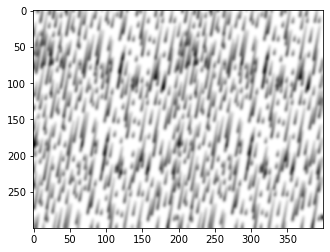

In [33]:
plt.imshow(im1LP, cmap="gray")

In [34]:
capture_LP = capture.copy()


# loop over the image, pixel by pixel
for y in range(0, h):
    for x in range(0, w):
        for c in range(0, 3):
            a = im1LP[y, x]/255.0
            capture_LP[y, x, c] = min(255, capture[y, x, c]*a)

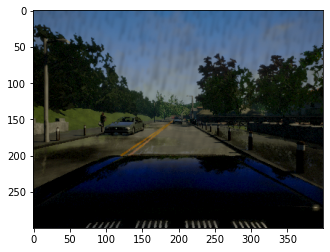

In [35]:
plt.imshow(capture_LP)